GROUP 6\
1.\
a. Objective of project: Predict BTC/USDT price trend in the next 1 hour\
b. Method of analysis: LSTMs, regression\
c. Dataset:\
-Independent variables: Open, Close, High, Low, Volume BTC, Volume USDT\
-Dependent variable: Close (price)\
-Column descriptions:\
● Unix: Unix timestamp is a digital standard for denoting an exact, universal time\
● Date and Time: Date and time of price with time interval of 1 hour\
● Open: BTC/USDT price first trade upon the start of the time period\
● Close: BTC/USDT price at the end of the time period\
● High: Highest BTC/USDT price during the 1 hour time period\
● Low: Lowest BTC/USDT price during the 1 hour time period\
● Volume BTC: Measure of how much of a given BTC has been traded in the time
period\
● Volume USDT: Measure of how much of a given USDT has been traded in
the time period\
● Tradecount: Number of trades

In [1]:
import pyspark.sql.functions as fn

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1626386089809_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2. Data Cleaning

2a. Reading from CSV

In [2]:
df = (
spark
.read
.csv(
's3://group6project/BTCUSDT Binance.csv'
, header=True
, inferSchema=True)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Drop symbol column because all data is about BTC/USDT prices:
df = df.drop('symbol')
df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+-------------------+--------+--------+--------+--------+-----------+------------------+----------+
|_c0|         unix|               date|    open|    high|     low|   close| Volume BTC|       Volume USDT|tradecount|
+---+-------------+-------------------+--------+--------+--------+--------+-----------+------------------+----------+
|  0|1624492800000|2021-06-24 00:00:00|33675.07|33879.99|33590.75|33615.13| 449.057483|1.51444422057383E7|    9231.0|
|  1|1624489200000|2021-06-23 23:00:00|33469.76|33749.11| 33251.0|33678.07|2214.913517|7.42996237627305E7|   45570.0|
|  2|1624485600000|2021-06-23 22:00:00|33335.01| 33587.0|33133.33|33469.85|2554.369099|8.53308163282183E7|   46967.0|
|  3|1624482000000|2021-06-23 21:00:00|33045.77|33785.26| 32985.5| 33335.0| 3332.77123|1.11004246609776E8|   67949.0|
|  4|1624478400000|2021-06-23 20:00:00| 32882.5|33295.79|32749.01|33045.78|4423.694685|1.46242299138994E8|   66149.0|
|  5|1624474800000|2021-06-23 19:00:00|33292.57|33568.96

In [4]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _c0: integer (nullable = true)
 |-- unix: long (nullable = true)
 |-- date: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- Volume BTC: double (nullable = true)
 |-- Volume USDT: double (nullable = true)
 |-- tradecount: double (nullable = true)

2b. Duplicated rows?

In [5]:
#Count total number of rows and total number of unique rows to check for duplicates / exact duplicates:
df.count(), df.distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(36399, 36399)

This indicates that all rows are distinct.

In [6]:
#Count total number of unix and total number of unique unix to check for duplicates:
df.agg(
      fn.count('unix').alias('CountOfUnix')
    , fn.countDistinct('unix').alias('CountOfDistinctUnix')
).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------------+
|CountOfUnix|CountOfDistinctUnix|
+-----------+-------------------+
|      36399|              36399|
+-----------+-------------------+

This indicates that all unix are distinct.

2c. Missing observations?

In [7]:
#Count percentage of missing values in each column:
for k, v in sorted(
    df.agg(*[
               (1 - (fn.count(c) / fn.count('*')))
                    .alias(c + '_miss')
               for c in df.columns
           ])
        .collect()[0]
        .asDict()
        .items()
    , key=lambda el: el[1]
    , reverse=True
):
    print(k, v)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tradecount_miss 0.7852962993488832
date_miss 2.747328223307033e-05
_c0_miss 0.0
unix_miss 0.0
open_miss 0.0
high_miss 0.0
low_miss 0.0
close_miss 0.0
Volume BTC_miss 0.0
Volume USDT_miss 0.0

Because tradecount column has 78.53% of missing values, it will be dropped. 

In [8]:
#Drop tradecount column:
no_tradecount = df.select([col for col in df.columns if col != 'tradecount'])
no_tradecount.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+-------------------+--------+--------+--------+--------+------------+--------------------+
|_c0|         unix|               date|    open|    high|     low|   close|  Volume BTC|         Volume USDT|
+---+-------------+-------------------+--------+--------+--------+--------+------------+--------------------+
|  0|1624492800000|2021-06-24 00:00:00|33675.07|33879.99|33590.75|33615.13|  449.057483|  1.51444422057383E7|
|  1|1624489200000|2021-06-23 23:00:00|33469.76|33749.11| 33251.0|33678.07| 2214.913517|  7.42996237627305E7|
|  2|1624485600000|2021-06-23 22:00:00|33335.01| 33587.0|33133.33|33469.85| 2554.369099|  8.53308163282183E7|
|  3|1624482000000|2021-06-23 21:00:00|33045.77|33785.26| 32985.5| 33335.0|  3332.77123|  1.11004246609776E8|
|  4|1624478400000|2021-06-23 20:00:00| 32882.5|33295.79|32749.01|33045.78| 4423.694685|  1.46242299138994E8|
|  5|1624474800000|2021-06-23 19:00:00|33292.57|33568.96|32870.99|32879.97| 3758.591851|  1.24896927871904E8|
|  6|16244

In [9]:
#Count the number of rows with missing values
no_tradecount.rdd.map(
           lambda row: (
                 row['unix']
               , sum([c == None for c in row])
           )
        )\
        .filter(lambda el: el[1] >= 1)\
        .count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1

There is 1 row with missing values.

In [10]:
#Count the number of missing values in that row:
(
    spark.createDataFrame(
        no_tradecount.rdd.map(
           lambda row: (
                 row['unix']
               , sum([c == None for c in row])
           )
        )
        .filter(lambda el: el[1] >= 1)
        .collect()
        ,['unix', 'CountMissing']
    )
    .orderBy('CountMissing', ascending=False)
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------+
|             unix|CountMissing|
+-----------------+------------+
|12628117525348800|           1|
+-----------------+------------+

There is 1 missing value in that row.

In [11]:
#View the row with missing values:
(
    no_tradecount
    .where('unix == 12628117525348800')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------------+----+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|  _c0|             unix|date|               open|               high|                low|              close|         Volume BTC|         Volume USDT|
+-----+-----------------+----+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|36398|12628117525348800|null|4.775442959899966E8|4.806080046300185E8|4.741987750199819E8|4.775714681399971E8|7.473220319429691E7|1.270546632178858...|
+-----+-----------------+----+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+

In [12]:
#Drop rows that have less than thresh NON-NULL values:
df_clean = no_tradecount.dropna(thresh = 9)
no_tradecount.count(), df_clean.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(36399, 36398)

One row is dropped.

In [13]:
#Making sure the row with missing value is gone
(
    df_clean
    .where('unix == 12628117525348800')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----+----+----+----+---+-----+----------+-----------+
|_c0|unix|date|open|high|low|close|Volume BTC|Volume USDT|
+---+----+----+----+----+---+-----+----------+-----------+
+---+----+----+----+----+---+-----+----------+-----------+

The row with missing value is gone now.

3. Descriptive statistics

In [14]:
#Describe numeric features:
numeric = ['open','high','low','close','Volume BTC','Volume USDT']
descriptive_stats = df_clean.describe(numeric)
descriptive_stats.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|              open|              high|               low|             close|        Volume BTC|         Volume USDT|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|             36398|             36398|             36398|             36398|             36398|               36398|
|   mean|13120.069673883087|13204.242118523503|13028.154706851528|13120.816202538523|2053.1953182674024|3.4907045227178924E7|
| stddev|12881.304946143066|12976.523164661266| 12777.51927864699|12881.777058786858|2161.3366843687263| 6.441459880648473E7|
|    min|            2919.0|            2950.0|            2817.0|            2919.0|               0.0|                 0.0|
|    max|          64577.25|           64854.0|           64280.0|          64577.26|          47255.76|   1.514464825

- Count: Each column has 36,398 values.\
- Mean: The means of open, high, low, close prices range from 13,028 to approximately 13,204 dollars. The difference between the means of high and low in an 1 hour is $176. On average, 2,053 BTCs and 34,907,045 USDT are being traded during the time period.\
- Standard deviation: Standard deviation gives a view of how widely values are dispersed from the average value. For example, if standard deviation of price is high, this indicates the price volatility. On the other hand, if the closing prices are close and do not fluctuate much from the average mean price, standard deviation is less and the markets volatility is considered less as well.\
- Min: This gives the min/lowest value of each column.\
- Max: This gives the max/highest value of each column.

Because unix and date data do not show anything meaningful, we do not do descriptive statistics on them.

4. Visualization

Histogram of Close

In [15]:
#generate bins and count of each bin
histogram_close = (
    df_clean
    .select('close')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_close
#display bin ranges
for i in range(len(histogram_close[0])-1):
    print('[' + str(round(histogram_close[0][i],2))
        + ',' + str(round(histogram_close[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[2919.0,6001.91)
[6001.91,9084.83)
[9084.83,12167.74)
[12167.74,15250.65)
[15250.65,18333.57)
[18333.57,21416.48)
[21416.48,24499.39)
[24499.39,27582.3)
[27582.3,30665.22)
[30665.22,33748.13)
[33748.13,36831.04)
[36831.04,39913.96)
[39913.96,42996.87)
[42996.87,46079.78)
[46079.78,49162.69)
[49162.69,52245.61)
[52245.61,55328.52)
[55328.52,58411.43)
[58411.43,61494.35)
[61494.35,64577.26)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

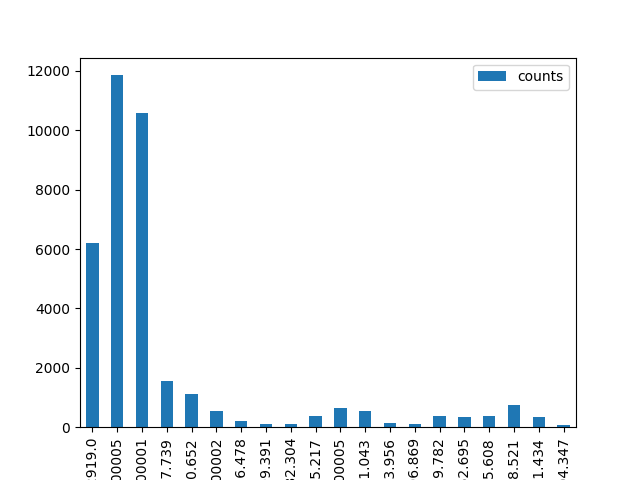

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
%%spark -o hist_close 
hist_close =  spark.createDataFrame(
    list(zip(*histogram_close)), 
    ['close', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_close.toPandas().set_index('close'
            ).plot(kind='bar')
%matplot plt

According to this histogram, close prices mostly range from 2,919 to 12,167. Some are between 30,665 and 39,913, and between 46,079 and 61,494. Close prices range from 6,001 to 9,084 for approximately 12,000 times. The distribution of close prices is right-skewed. This indicates that the likelihood of an extremely large price is somewhat greater than the likelihood of an extremely low price. The close prices of BTC/USDT are not normally distributed.

Histogram of High

In [17]:
histogram_high = (
    df_clean
    .select('high')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
for i in range(len(histogram_high[0])-1):
    print('[' + str(round(histogram_high[0][i],2))
        + ',' + str(round(histogram_high[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[2950.0,6045.2)
[6045.2,9140.4)
[9140.4,12235.6)
[12235.6,15330.8)
[15330.8,18426.0)
[18426.0,21521.2)
[21521.2,24616.4)
[24616.4,27711.6)
[27711.6,30806.8)
[30806.8,33902.0)
[33902.0,36997.2)
[36997.2,40092.4)
[40092.4,43187.6)
[43187.6,46282.8)
[46282.8,49378.0)
[49378.0,52473.2)
[52473.2,55568.4)
[55568.4,58663.6)
[58663.6,61758.8)
[61758.8,64854.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

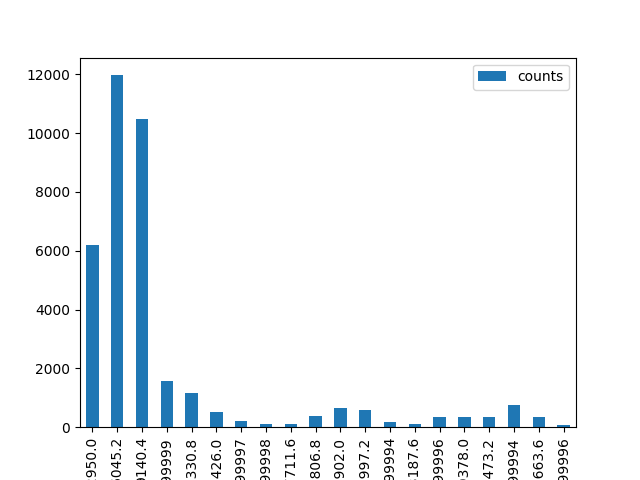

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
%%spark -o hist_high
hist_high =  spark.createDataFrame(
    list(zip(*histogram_high)), 
    ['high', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_high.toPandas().set_index('high'
            ).plot(kind='bar')
%matplot plt

High prices mostly range from 2,950 to 12,235. Some are between 30,806 and 40,092, and between 46,282 and 61,758. High prices range from 6,045 to 9,140 for approximately 12,000 times. The distribution of high prices is right-skewed. This indicates that the likelihood of an extremely large price is somewhat greater than the likelihood of an extremely low price. The high prices of BTC/USDT are not normally distributed.

Histogram of low

In [19]:
histogram_low = (
    df_clean
    .select('low')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
for i in range(len(histogram_low[0])-1):
    print('[' + str(round(histogram_low[0][i],2))
        + ',' + str(round(histogram_low[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[2817.0,5890.15)
[5890.15,8963.3)
[8963.3,12036.45)
[12036.45,15109.6)
[15109.6,18182.75)
[18182.75,21255.9)
[21255.9,24329.05)
[24329.05,27402.2)
[27402.2,30475.35)
[30475.35,33548.5)
[33548.5,36621.65)
[36621.65,39694.8)
[39694.8,42767.95)
[42767.95,45841.1)
[45841.1,48914.25)
[48914.25,51987.4)
[51987.4,55060.55)
[55060.55,58133.7)
[58133.7,61206.85)
[61206.85,64280.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

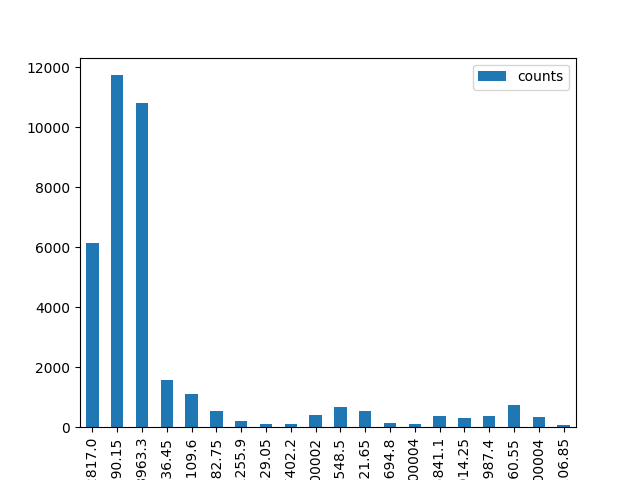

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
%%spark -o hist_low
hist_low =  spark.createDataFrame(
    list(zip(*histogram_low)), 
    ['low', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_low.toPandas().set_index('low'
            ).plot(kind='bar')
%matplot plt

Low prices mostly range from 2,817 to 12,036. Some are between 30,475 and 39,694, and between 45,841 and 61,206. Low prices range from 5,890 to 8,963 for approximately 12,000 times. The distribution of low prices is right-skewed. This indicates that the likelihood of an extremely large price is somewhat greater than the likelihood of an extremely low price. The low prices of BTC/USDT are not normally distributed.

Histogram of open

In [21]:
histogram_open = (
    df_clean
    .select('open')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
for i in range(len(histogram_open[0])-1):
    print('[' + str(round(histogram_open[0][i],2))
        + ',' + str(round(histogram_open[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[2919.0,6001.91)
[6001.91,9084.83)
[9084.83,12167.74)
[12167.74,15250.65)
[15250.65,18333.56)
[18333.56,21416.47)
[21416.47,24499.39)
[24499.39,27582.3)
[27582.3,30665.21)
[30665.21,33748.12)
[33748.12,36831.04)
[36831.04,39913.95)
[39913.95,42996.86)
[42996.86,46079.78)
[46079.78,49162.69)
[49162.69,52245.6)
[52245.6,55328.51)
[55328.51,58411.42)
[58411.42,61494.34)
[61494.34,64577.25)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

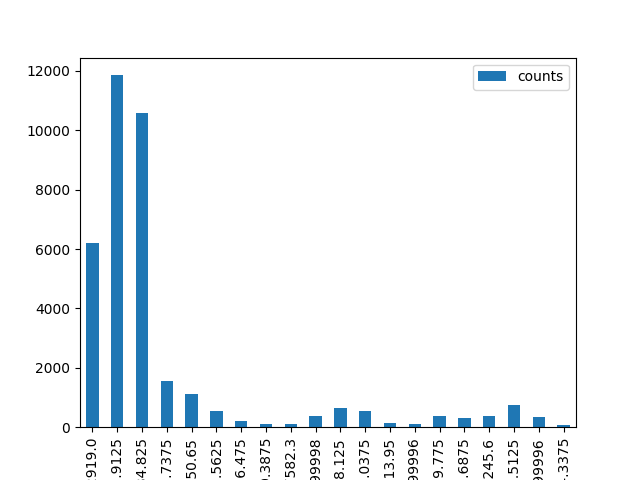

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
%%spark -o hist_open
hist_open =  spark.createDataFrame(
    list(zip(*histogram_open)), 
    ['open', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_open.toPandas().set_index('open'
            ).plot(kind='bar')
%matplot plt

Open prices mostly range from 2,919 to 12,167. Some are between 30,665 and 39,913, and between 46,079 and 61,494. Open prices range from 6,001 to 9,084 for approximately 12,000 times. The distribution of open prices is right-skewed. This indicates that the likelihood of an extremely large price is somewhat greater than the likelihood of an extremely low price. The low prices of BTC/USDT are not normally distributed.

Histogram of Volume BTC

In [23]:
histogram_volBTC = (
    df_clean
    .select('Volume BTC')
    .rdd
    .flatMap(lambda record: record)
    .histogram(30)
)
for i in range(len(histogram_volBTC[0])-1):
    print('[' + str(round(histogram_volBTC[0][i],2))
        + ',' + str(round(histogram_volBTC[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.0,1575.19)
[1575.19,3150.38)
[3150.38,4725.58)
[4725.58,6300.77)
[6300.77,7875.96)
[7875.96,9451.15)
[9451.15,11026.34)
[11026.34,12601.54)
[12601.54,14176.73)
[14176.73,15751.92)
[15751.92,17327.11)
[17327.11,18902.3)
[18902.3,20477.5)
[20477.5,22052.69)
[22052.69,23627.88)
[23627.88,25203.07)
[25203.07,26778.26)
[26778.26,28353.46)
[28353.46,29928.65)
[29928.65,31503.84)
[31503.84,33079.03)
[33079.03,34654.22)
[34654.22,36229.42)
[36229.42,37804.61)
[37804.61,39379.8)
[39379.8,40954.99)
[40954.99,42530.18)
[42530.18,44105.38)
[44105.38,45680.57)
[45680.57,47255.76)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

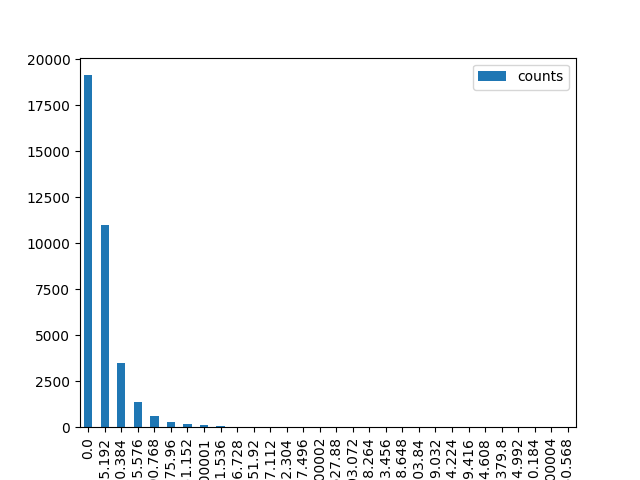

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
%%spark -o hist_volBTC
hist_volBTC =  spark.createDataFrame(
    list(zip(*histogram_volBTC)), 
    ['Volume BTC', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_volBTC.toPandas().set_index('Volume BTC'
            ).plot(kind='bar')
%matplot plt

The distribution of Volume BTC is positively skewed. Most Volume BTC are between 0 and 3,150. In 1 hour, approximately 0 to 1,575 BTC were traded with the higest frequency of 19,000.

Histogram of USDT

In [25]:
histogram_volUSDT = (
    df_clean
    .select('Volume USDT')
    .rdd
    .flatMap(lambda record: record)
    .histogram(30)
)
for i in range(len(histogram_volUSDT[0])-1):
    print('[' + str(round(histogram_volUSDT[0][i],2))
        + ',' + str(round(histogram_volUSDT[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.0,50482160.84)
[50482160.84,100964321.68)
[100964321.68,151446482.52)
[151446482.52,201928643.36)
[201928643.36,252410804.2)
[252410804.2,302892965.04)
[302892965.04,353375125.88)
[353375125.88,403857286.72)
[403857286.72,454339447.57)
[454339447.57,504821608.41)
[504821608.41,555303769.25)
[555303769.25,605785930.09)
[605785930.09,656268090.93)
[656268090.93,706750251.77)
[706750251.77,757232412.61)
[757232412.61,807714573.45)
[807714573.45,858196734.29)
[858196734.29,908678895.13)
[908678895.13,959161055.97)
[959161055.97,1009643216.81)
[1009643216.81,1060125377.65)
[1060125377.65,1110607538.49)
[1110607538.49,1161089699.33)
[1161089699.33,1211571860.17)
[1211571860.17,1262054021.02)
[1262054021.02,1312536181.86)
[1312536181.86,1363018342.7)
[1363018342.7,1413500503.54)
[1413500503.54,1463982664.38)
[1463982664.38,1514464825.22)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

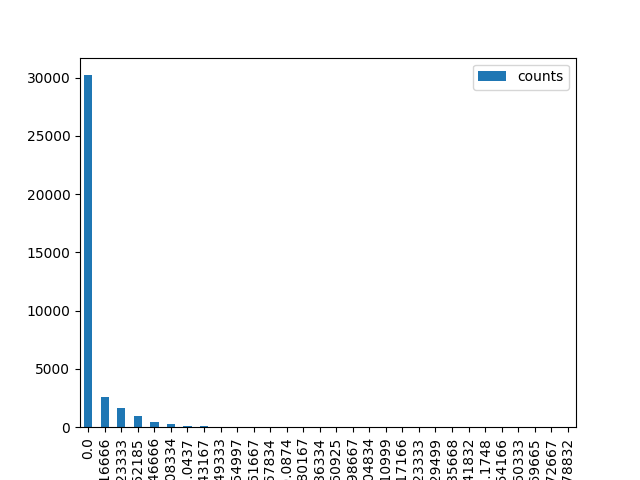

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
%%spark -o hist_volUSDT
hist_volUSDT =  spark.createDataFrame(
    list(zip(*histogram_volUSDT)), 
    ['Volume USDT', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_volUSDT.toPandas().set_index('Volume USDT'
            ).plot(kind='bar')
%matplot plt

The distribution of Volume USDT is positively skewed. Most Volume USDT are between 0 and 50,482,160 with the higest frequency of 30,000.

In [ ]:
df_pd = df_clean.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#Scatter Plot for Low and Volume BTC
import matplotlib.pyplot as plt
plt.cla()
plt.scatter(df_pd['low']
         , df_pd['Volume BTC'], 
            label="Relationship between low and Volume BTC")
plt.xlabel("low")
plt.ylabel("Volume BTC")
plt.legend(loc='upper left')
%matplot plt

The relationship between Low and Volume BTC is cointigrated. Most of the time, a big increase in Low will cause Volume BTC to increase and a big decrease in Low will cause Volume BTC to decrease. By looking at the chart, we can see some outliers at the range above 30,000.

In [ ]:
#Scatter Plot for High and Volume BTC
import matplotlib.pyplot as plt
plt.cla()
plt.scatter(df_pd['high']
         , df_pd['Volume BTC'], 
            label="Relationship between high and Volume BTC")
plt.xlabel("high")
plt.ylabel("Volume BTC")
plt.legend(loc='upper left')
%matplot plt

The relationship between High and Volume BTC is cointigrated. Most of the time, a big increase in High will cause Volume BTC to increase and a big decrease in High will cause Volume BTC to decrease. By looking at the chart, we can see some outliers at the range above 30,000.

In [ ]:
#Scatter Plot for close and Volume BTC
import matplotlib.pyplot as plt
plt.cla()
plt.scatter(df_pd['close']
         , df_pd['Volume BTC'], 
            label="Relationship between close and Volume BTC")
plt.xlabel("close")
plt.ylabel("Volume BTC")
plt.legend(loc='upper left')
%matplot plt

The relationship between Close and Volume BTC is cointigrated. Most of the time, a big increase in Close will cause Volume BTC to increase and a big decrease in Close will cause Volume BTC to decrease.

In [ ]:
#Scatter Plot for Volume BTC and Volume USDT
import matplotlib.pyplot as plt
plt.cla()
plt.scatter(df_pd['Volume BTC']
         , df_pd['Volume USDT'], 
            label="Relationship between Volume BTC and Volume USDT")
plt.xlabel("Volume BTC")
plt.ylabel("Volume USDT")
plt.legend(loc='upper left')
%matplot plt

The BTC Volume and the USDT volume are positive correlated. Because of the exchange rate between BTC and USDT, they go in slightly different direction.

5. Outlier analysis

Identify outliers based on visualization:\
As we can see from the charts, the outliers of Volume BTC are those above 30000, the outliers of Volume USDT are those above 1000000000, the outliers of prices (open, close, high, low) are those above 59000.

In [ ]:
#Filter outliers
df_no_outlier = df_clean.where((df_clean['Volume BTC'] < 30000) & (df_clean['Volume USDT'] < 1000000000) & (df_clean['open'] < 59000) & (df_clean['close'] < 59000) &(df_clean['high'] < 59000) &(df_clean['low'] < 59000))

Approximately 1% of the data are outliers and were eliminated.

6.

In [ ]:
#Rerun descriptive statistics
stat_no_outlier = df_no_outlier.describe(numeric)
stat_no_outlier.show(10)

Redraw histograms

Histogram of numeric features

Histogram of close price

In [ ]:
#generate bins and count of each bin
histogram_close1 = (
    df_no_outlier
    .select('close')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_close1
#display bin ranges
for i in range(len(histogram_close1[0])-1):
    print('[' + str(round(histogram_close1[0][i],2))
        + ',' + str(round(histogram_close1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_close1 
hist_close1 =  spark.createDataFrame(
    list(zip(*histogram_close1)), 
    ['close', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_close1.toPandas().set_index('close'
            ).plot(kind='bar')
%matplot plt

Histogram of open price

In [ ]:
#generate bins and count of each bin
histogram_open1 = (
    df_no_outlier
    .select('open')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_open1
#display bin ranges
for i in range(len(histogram_open1[0])-1):
    print('[' + str(round(histogram_open1[0][i],2))
        + ',' + str(round(histogram_open1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_open1 
hist_open1 =  spark.createDataFrame(
    list(zip(*histogram_open1)), 
    ['open', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_open1.toPandas().set_index('open'
            ).plot(kind='bar')
%matplot plt

Histogram of low price

In [ ]:
#generate bins and count of each bin
histogram_low1 = (
    df_no_outlier
    .select('low')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_low1
#display bin ranges
for i in range(len(histogram_low1[0])-1):
    print('[' + str(round(histogram_low1[0][i],2))
        + ',' + str(round(histogram_low1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_low1 
hist_low1 =  spark.createDataFrame(
    list(zip(*histogram_low1)), 
    ['low', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_low1.toPandas().set_index('low'
            ).plot(kind='bar')
%matplot plt

Histogram of high price

In [ ]:
#generate bins and count of each bin
histogram_high1 = (
    df_no_outlier
    .select('high')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_high1
#display bin ranges
for i in range(len(histogram_high1[0])-1):
    print('[' + str(round(histogram_high1[0][i],2))
        + ',' + str(round(histogram_high1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_high1
hist_high1 =  spark.createDataFrame(
    list(zip(*histogram_high1)), 
    ['high', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_high1.toPandas().set_index('high'
            ).plot(kind='bar')
%matplot plt

Histogram of volume BTC

In [ ]:
#generate bins and count of each bin
histogram_volumeBTC1 = (
    df_no_outlier
    .select('Volume BTC')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_volumeBTC1
#display bin ranges
for i in range(len(histogram_volumeBTC1[0])-1):
    print('[' + str(round(histogram_volumeBTC1[0][i],2))
        + ',' + str(round(histogram_volumeBTC1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_volumeBTC1 
hist_volumeBTC1 =  spark.createDataFrame(
    list(zip(*histogram_volumeBTC1)), 
    ['Volume BTC', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_volumeBTC1.toPandas().set_index('Volume BTC'
            ).plot(kind='bar')
%matplot plt

Histogram of Volume USDT

In [ ]:
#generate bins and count of each bin
histogram_volumeUSDT1 = (
    df_no_outlier
    .select('Volume USDT')
    .rdd
    .flatMap(lambda record: record)
    .histogram(20)
)
histogram_volumeUSDT1
#display bin ranges
for i in range(len(histogram_volumeUSDT1[0])-1):
    print('[' + str(round(histogram_volumeUSDT1[0][i],2))
        + ',' + str(round(histogram_volumeUSDT1[0][i+1],2))
          + ')'
         )

In [ ]:
%%spark -o hist_volumeUSDT1
hist_volumeUSDT1 =  spark.createDataFrame(
    list(zip(*histogram_volumeUSDT1)), 
    ['Volume USDT', 'counts'])
import matplotlib
import matplotlib.pyplot as plt
hist_volumeUSDT1.toPandas().set_index('Volume USDT'
            ).plot(kind='bar')
%matplot plt